In [ ]:
!pip install torchviz

In [ ]:
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader 
from torchvision import transforms,datasets,models
from torchviz import make_dot

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
batchSize = 128
composed_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406],
                                                              [0.229, 0.224, 0.225])])
                                  

#Loading Train dataset
train_dataPath = "/content/drive/My Drive/cv assignment-3/TrainSet"

train_data = datasets.ImageFolder(root=train_dataPath, transform=composed_transform)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batchSize)

#Loading test dataset
test_composed_transform = transforms.Compose([transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406],
                                                              [0.229, 0.224, 0.225])])
test_dataPath = "/content/drive/My Drive/cv assignment-3/TestSet"

test_data = datasets.ImageFolder(root=test_dataPath, transform=test_composed_transform)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batchSize)


In [ ]:
class Resblock(nn.Module):
  def __init__(self,in_channels,out_channels,stride=1,dim_change=None):
    super(Resblock,self).__init__()

    self.conv1 = nn.Conv2d(in_channels,out_channels,kernel_size=3,stride=stride,padding=1)
    self.bn1 = nn.BatchNorm2d(out_channels)
    
    self.conv2 = nn.Conv2d(out_channels,out_channels,kernel_size=3,stride=1,padding=1)
    self.bn2 = nn.BatchNorm2d(out_channels)

    self.dim_change = dim_change

  def forward(self,x):
    x_shortcut = x

    x=self.conv1(x)
    x=self.bn1(x)
    x=F.relu(x)

    x=self.conv2(x)
    x=self.bn2(x)

    if self.dim_change is not None:
      x_shortcut = self.dim_change(x_shortcut)

    x+=x_shortcut
    x=F.relu(x)

    return x




In [ ]:
class Resnet_18(nn.Module):
  def __init__(self,block,num_classes=8):
    super(Resnet_18,self).__init__()

    self.conv1 = nn.Conv2d(3,64,kernel_size=7,stride=2)
    self.bn1 = nn.BatchNorm2d(64)
    
    self.maxpool1 = nn.MaxPool2d(kernel_size=3,stride=2)

    self.in_channels = 64

    self.layer1 = self.make_layer(block,64,2,1)
    self.layer2 = self.make_layer(block,128,2,2)
    self.layer3 = self.make_layer(block,256,2,2)
    self.layer4 = self.make_layer(block,512,2,2)

    self.avg_pool = nn.AdaptiveAvgPool2d(output_size=1)
    self.fc = nn.Linear(512,num_classes)


  def make_layer(self,block,out_channels,num_layers,stride):
    dim_change=None

    if (self.in_channels != out_channels) or (stride != 1):
      dim_change= nn.Sequential(
                                  nn.Conv2d(self.in_channels,out_channels,kernel_size=1,stride=stride),
                                  nn.BatchNorm2d(out_channels)
                                )
      
    layers=[]
    layers.append(block(self.in_channels,out_channels,stride,dim_change))

    self.in_channels = out_channels

    for i in range(1,num_layers):
      layers.append(block(self.in_channels,out_channels))

    return nn.Sequential(*layers)   

  def forward(self,x):
    x=self.conv1(x)
    x=self.bn1(x)
    

    x=self.maxpool1(x)
    x=F.relu(x)

    x=self.layer1(x)
    x=self.layer2(x)
    x=self.layer3(x)
    x=self.layer4(x)

    x=self.avg_pool(x)
    x=x.reshape(-1,512)
    x=self.fc(x)

    return x


In [ ]:
model = Resnet_18(Resblock,8)

In [ ]:
model

Resnet_18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Resblock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Resblock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

In [ ]:
x = torch.zeros(128, 3, 256, 256, dtype=torch.float, requires_grad=False)
out = model(x)
make_dot(out)

In [ ]:
model=model.cuda()
model = nn.DataParallel(model)

In [ ]:
criterion=nn.CrossEntropyLoss().cuda()

optimizer = optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
epochs=100

In [ ]:
def train_model(model,train_loader,validation_loader,criterion,optimizer,scheduler,epochs):
  loss_list_train=[]
  loss_list_test=[]
  accuracy_list_train=[]
  accuracy_list_test=[]
  
  for epoch in range(epochs):
    total=total_test=0
    cost_train=cost_test=matched_train=matched_test=0
    print("Epoch : ",epoch+1,"/",epochs)
    # scheduler.step()
    model.train()
    for x,y in train_loader:

      total+=y.size(0)
      x,y=x.cuda(),y.cuda()


      optimizer.zero_grad()
      y_out=model(x)
      _,yout_train = torch.max(y_out.data,1)
      matched_train+=(yout_train==y).sum().item()
     
    
      loss_train=criterion(y_out,y)
      loss_train.backward()
      optimizer.step()
      scheduler.step()
      cost_train+=loss_train.item()
    accuracy_list_train.append(matched_train/total)  
    loss_list_train.append(cost_train/total)




    model.eval()

    for x_test,y_test in validation_loader:

      total_test+=y_test.size(0)

      x_test,y_test=x_test.cuda(),y_test.cuda()   
      z=model(x_test)

      _,yout = torch.max(z.data,1)

      matched_test+=(yout==y_test).sum().item()

      loss_test=criterion(z,y_test)
      cost_test+=loss_test.item()

    accuracy_test=matched_test/total_test

    accuracy_list_test.append(accuracy_test)
    loss_list_test.append(cost_test/total)

    print('loss = ',cost_train) 
    print("acc = ",accuracy_test)

  return loss_list_train,loss_list_test,accuracy_list_train,accuracy_list_test    

In [ ]:
loss_list_train,loss_list_test,accuracy_list_train,accuracy_list_test=train_model(model,train_loader,test_loader,criterion,optimizer,scheduler,epochs)

Epoch :  1 / 100
loss =  24.604697823524475
acc =  0.3
Epoch :  2 / 100
loss =  16.807419180870056
acc =  0.5901234567901235
Epoch :  3 / 100
loss =  16.241345584392548
acc =  0.5987654320987654
Epoch :  4 / 100
loss =  16.386307060718536
acc =  0.6111111111111112
Epoch :  5 / 100
loss =  16.390953421592712
acc =  0.6074074074074074
Epoch :  6 / 100
loss =  16.240960359573364
acc =  0.6123456790123457
Epoch :  7 / 100
loss =  16.390207946300507
acc =  0.6098765432098765
Epoch :  8 / 100
loss =  16.339368879795074
acc =  0.608641975308642
Epoch :  9 / 100
loss =  16.411459803581238
acc =  0.6049382716049383
Epoch :  10 / 100
loss =  16.375258088111877
acc =  0.608641975308642
Epoch :  11 / 100
loss =  16.264905035495758
acc =  0.6049382716049383
Epoch :  12 / 100
loss =  16.405873656272888
acc =  0.6037037037037037
Epoch :  13 / 100
loss =  16.26304417848587
acc =  0.608641975308642
Epoch :  14 / 100
loss =  16.295102536678314
acc =  0.6135802469135803
Epoch :  15 / 100
loss =  16.32812

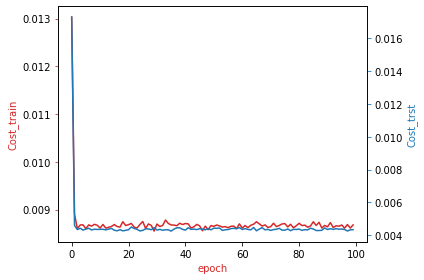

In [ ]:
fig,ax1 = plt.subplots()
color='tab:red'
ax1.plot(loss_list_train,color=color)
ax1.set_xlabel('epoch',color=color)
ax1.set_ylabel('Cost_train',color=color)
ax1.tick_params(axis='y',color=color)

ax2=ax1.twinx()
color='tab:blue'
ax2.set_ylabel('Cost_trst',color=color)
ax2.set_xlabel('epoch',color=color)
ax2.plot(loss_list_test,color=color)
ax2.tick_params(axis='y',color=color)
fig.tight_layout()

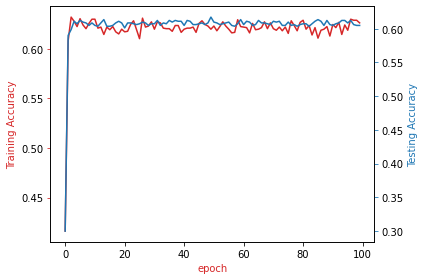

In [ ]:
fig,ax1 = plt.subplots()
color='tab:red'
ax1.plot(accuracy_list_train,color=color)
ax1.set_xlabel('epoch',color=color)
ax1.set_ylabel('Training Accuracy',color=color)
ax1.tick_params(axis='y',color=color)

ax2=ax1.twinx()
color='tab:blue'
ax2.set_ylabel('Testing Accuracy',color=color)
ax2.set_xlabel('epoch',color=color)
ax2.plot(accuracy_list_test,color=color)
ax2.tick_params(axis='y',color=color)
fig.tight_layout()